## Import des libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import gdown
import os
!pip install torchinfo
from torchinfo import summary


## Téléchargement du dataset

In [23]:
#Téléchargement du dataset
url = 'https://drive.google.com/uc?id=1KIX6QASxnWGPJcQ_Q-W8O1UPSbPA4uat'
output = './dataset.zip'
if not os.path.exists(output):
	gdown.download(url, output, quiet=False)

#Dézippage du dataset

def unzip(zip_file, dest_dir):
	import zipfile
	with zipfile.ZipFile(zip_file, 'r') as zip_ref:
		zip_ref.extractall(dest_dir)

unzip('dataset.zip', './')

Downloading...
From (original): https://drive.google.com/uc?id=1KIX6QASxnWGPJcQ_Q-W8O1UPSbPA4uat
From (redirected): https://drive.google.com/uc?id=1KIX6QASxnWGPJcQ_Q-W8O1UPSbPA4uat&confirm=t&uuid=f86e3a37-e174-4a3e-96bd-55f5f1d1c169
To: /content/dataset.zip
100%|██████████| 103M/103M [00:02<00:00, 48.5MB/s] 


## Load le dataset

In [1]:
X_train = np.load('X_train.npy')
X_clean_train = np.load('X_clean_train.npy')
X_test = np.load('X_test.npy')

print(X_train.shape)
print(X_clean_train.shape)
print(X_test.shape)

NameError: name 'np' is not defined

## Affichage des données

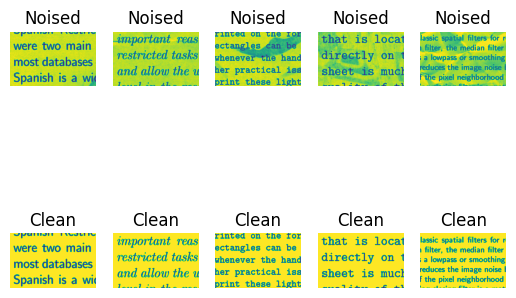

In [ ]:
import matplotlib.pyplot as plt

# first row show 5 noised images, second row show 5 clean images
for i in range(5):
	plt.subplot(2, 5, i + 1)
	plt.imshow(X_train[i])
	plt.title("Noised")
	plt.axis('off')

	plt.subplot(2, 5, i + 6)
	plt.imshow(X_clean_train[i])
	plt.title("Clean")
	plt.axis('off')

plt.show()

## Batch les données

In [ ]:
batch_size = 20
width = X_train.shape[1]
height = X_train.shape[2]
X_train_reshaped = X_train.reshape(-1, batch_size, width, height)
X_clean_train_reshaped = X_clean_train.reshape(-1, batch_size, width, height)

print(X_train_reshaped.shape)
print(X_clean_train_reshaped.shape)

(95, 20, 128, 200)
(95, 20, 128, 200)


## Ajouter la dimension de couleur
Pour l'instant, nos images sont de shape (width, height). Les couches de convolution veulent des images de shape (color, width, height). On va donc ajouter une dimension de couleur à nos images.

In [ ]:
X_train_expanded = np.expand_dims(X_train_reshaped, axis=2)
X_clean_train_expanded = np.expand_dims(X_clean_train_reshaped, axis=2)

print(X_train_expanded.shape)
print(X_clean_train_expanded.shape)

(95, 20, 1, 128, 200)
(95, 20, 1, 128, 200)


## Convertir les données en torch.tensor

In [ ]:
X_train_torch = torch.from_numpy(X_train_expanded).float()
X_clean_train_torch = torch.from_numpy(X_clean_train_expanded).float()

## Créer le modèle

In [ ]:
class Encoder(nn.Module):
	def __init__(self):
		super().__init__()
		self.relu = nn.ReLU()
		self.conv2d_1 = nn.Conv2d(1, 32, 3, 1, padding='same')
		self.maxpooling2d_1 = nn.MaxPool2d(3, 2, 1)

		self.conv2d_2 = nn.Conv2d(32, 64, 3, 1, padding='same')
		self.maxpooling2d_2 = nn.MaxPool2d(3, 2, 1)

		self.conv2d_3 = nn.Conv2d(64, 128, 3, 1, padding='same')
		self.maxpooling2d_3 = nn.MaxPool2d(3, 2, 0)

		self.conv2d_4 = nn.Conv2d(128, 256, 3, 1, padding='same')
		self.maxpooling2d_4 = nn.MaxPool2d(3, 2, 0)

		self.conv2d_5 = nn.Conv2d(256, 256, 3, 1, padding='same')

	def forward(self, x):
		out_conv2d_1 = self.conv2d_1(x)
		x = self.relu(out_conv2d_1)
		x = self.maxpooling2d_1(x)

		out_conv2d_2 = self.conv2d_2(x)
		x = self.relu(out_conv2d_2)
		x = self.maxpooling2d_2(x)

		out_conv2d_3 = self.conv2d_3(x)
		x = self.relu(out_conv2d_3)
		x = self.maxpooling2d_3(x)

		out_conv2d_4 = self.conv2d_4(x)
		x = self.relu(out_conv2d_4)
		x = self.maxpooling2d_4(x)

		out_conv2d_5 = self.conv2d_5(x)

		return [out_conv2d_1, out_conv2d_2, out_conv2d_3, out_conv2d_4, out_conv2d_5]

In [ ]:
batch_size = 5
encoder = Encoder()
summary(encoder, input_size=(batch_size, 1, 128, 200))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [5, 32, 128, 200]         --
├─Conv2d: 1-1                            [5, 32, 128, 200]         320
├─ReLU: 1-2                              [5, 32, 128, 200]         --
├─MaxPool2d: 1-3                         [5, 32, 64, 100]          --
├─Conv2d: 1-4                            [5, 64, 64, 100]          18,496
├─ReLU: 1-5                              [5, 64, 64, 100]          --
├─MaxPool2d: 1-6                         [5, 64, 32, 50]           --
├─Conv2d: 1-7                            [5, 128, 32, 50]          73,856
├─ReLU: 1-8                              [5, 128, 32, 50]          --
├─MaxPool2d: 1-9                         [5, 128, 15, 24]          --
├─Conv2d: 1-10                           [5, 256, 15, 24]          295,168
├─ReLU: 1-11                             [5, 256, 15, 24]          --
├─MaxPool2d: 1-12                        [5, 256, 7, 11]           --
├

In [ ]:
class Decoder(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv2d_transpose_1 = nn.ConvTranspose2d(256, 256, 3, 2, 0, (0,1))
		self.conv2d_6 = nn.Conv2d(512, 256, 3, 1, padding='same')

		self.conv2d_transpose_2 = nn.ConvTranspose2d(256, 128, 4, 2, 0)
		self.conv2d_7 = nn.Conv2d(256, 128, 3, 1, padding='same')

		self.conv2d_transpose_3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
		self.conv2d_8 = nn.Conv2d(128, 64, 3, 1, padding='same')

		self.conv2d_transpose_4 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
		self.conv2d_9 = nn.Conv2d(64, 1, 3, 1, padding='same')
		self.relu = nn.ReLU()

	def forward(self, *encoder_outputs):
		x = self.conv2d_transpose_1(encoder_outputs[-1])
		x = self.relu(x)
		x = torch.cat((x, encoder_outputs[-2]), 1)
		x = self.conv2d_6(x)
		x = self.relu(x)

		x = self.conv2d_transpose_2(x)
		x = self.relu(x)
		x = torch.cat((x, encoder_outputs[-3]), 1)
		x = self.conv2d_7(x)
		x = self.relu(x)

		x = self.conv2d_transpose_3(x)
		x = self.relu(x)
		x = torch.cat((x, encoder_outputs[-4]), 1)
		x = self.conv2d_8(x)
		x = self.relu(x)

		x = self.conv2d_transpose_4(x)
		x = self.relu(x)
		x = torch.cat((x, encoder_outputs[-5]), 1)
		x = self.conv2d_9(x)
		x = self.relu(x)

		return x



In [ ]:
batch_size = 5
decoder = Decoder()
summary(decoder, input_size=[(batch_size, 32, 128, 200), (batch_size, 64, 64, 100), (batch_size, 128, 32, 50), (batch_size, 256, 15, 24), (batch_size, 256, 7, 11)])

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [5, 1, 128, 200]          --
├─ConvTranspose2d: 1-1                   [5, 256, 15, 24]          590,080
├─ReLU: 1-2                              [5, 256, 15, 24]          --
├─Conv2d: 1-3                            [5, 256, 15, 24]          1,179,904
├─ReLU: 1-4                              [5, 256, 15, 24]          --
├─ConvTranspose2d: 1-5                   [5, 128, 32, 50]          524,416
├─ReLU: 1-6                              [5, 128, 32, 50]          --
├─Conv2d: 1-7                            [5, 128, 32, 50]          295,040
├─ReLU: 1-8                              [5, 128, 32, 50]          --
├─ConvTranspose2d: 1-9                   [5, 64, 64, 100]          131,136
├─ReLU: 1-10                             [5, 64, 64, 100]          --
├─Conv2d: 1-11                           [5, 64, 64, 100]          73,792
├─ReLU: 1-12                             [5, 64, 64, 1

In [ ]:
class Unet(nn.Module):
	def __init__(self):
		super().__init__()
		self.encoder = Encoder()
		self.decoder = Decoder()

	def forward(self, x):
		outs = self.encoder(x)
		out = self.decoder(*outs)
		return out

In [ ]:
batch_size = 5
unet = Unet()
summary(unet, input_size=(batch_size, 1, 128, 200))

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [5, 1, 128, 200]          --
├─Encoder: 1-1                           [5, 32, 128, 200]         --
│    └─Conv2d: 2-1                       [5, 32, 128, 200]         320
│    └─ReLU: 2-2                         [5, 32, 128, 200]         --
│    └─MaxPool2d: 2-3                    [5, 32, 64, 100]          --
│    └─Conv2d: 2-4                       [5, 64, 64, 100]          18,496
│    └─ReLU: 2-5                         [5, 64, 64, 100]          --
│    └─MaxPool2d: 2-6                    [5, 64, 32, 50]           --
│    └─Conv2d: 2-7                       [5, 128, 32, 50]          73,856
│    └─ReLU: 2-8                         [5, 128, 32, 50]          --
│    └─MaxPool2d: 2-9                    [5, 128, 15, 24]          --
│    └─Conv2d: 2-10                      [5, 256, 15, 24]          295,168
│    └─ReLU: 2-11                        [5, 256, 15, 24]          --
│

## Boucle d'entraînement

In [ ]:
device = torch.device('cuda')

Epoch 0, loss 0.04496


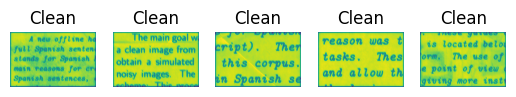

Epoch 3, loss 0.01374


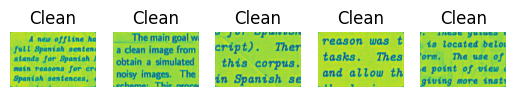

Epoch 6, loss 0.00829


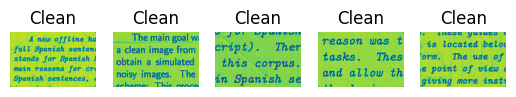

Epoch 9, loss 0.00603


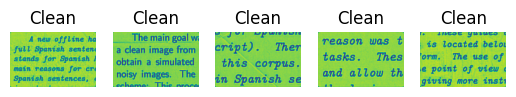

Epoch 12, loss 0.00475


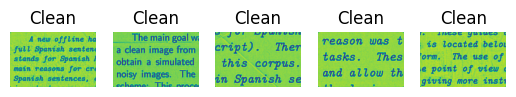

Epoch 15, loss 0.00389


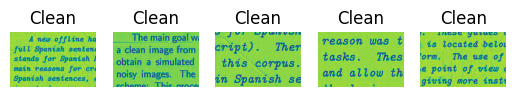

Epoch 18, loss 0.00329


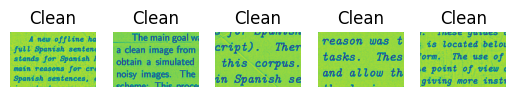

Epoch 21, loss 0.00287


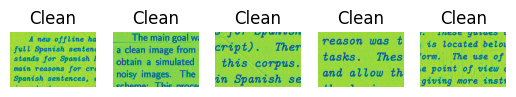

Epoch 24, loss 0.00257


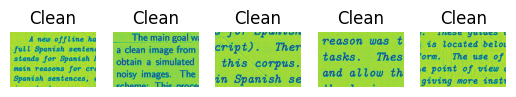

Epoch 27, loss 0.00229


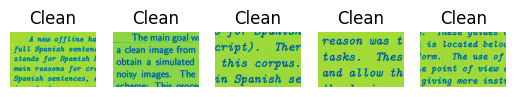

Epoch 30, loss 0.00207


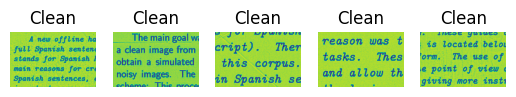

Epoch 33, loss 0.00195


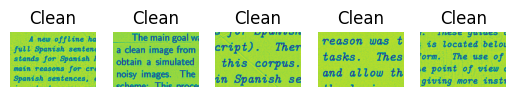

Epoch 36, loss 0.00183


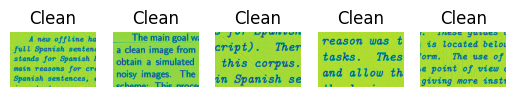

Epoch 39, loss 0.00174


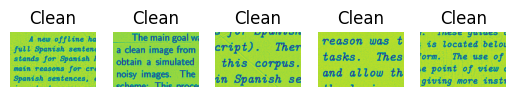

Epoch 42, loss 0.00166


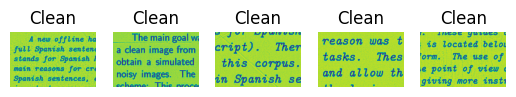

Epoch 45, loss 0.00158


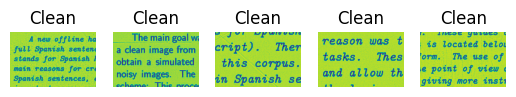

Epoch 48, loss 0.00152


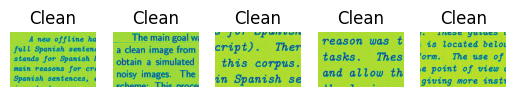

Epoch 51, loss 0.00150


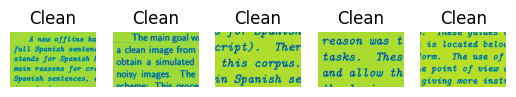

Epoch 54, loss 0.00144


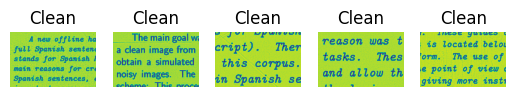

Epoch 57, loss 0.00137


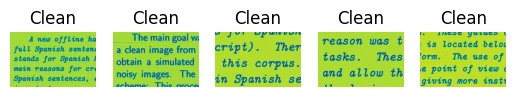

Epoch 60, loss 0.00133


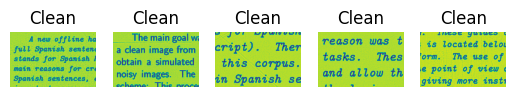

Epoch 63, loss 0.00129


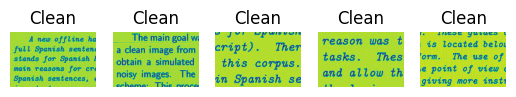

Epoch 66, loss 0.00125


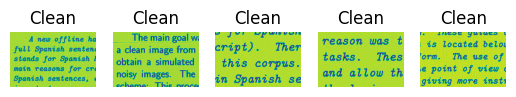

Epoch 69, loss 0.00121


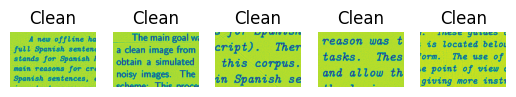

Epoch 72, loss 0.00119


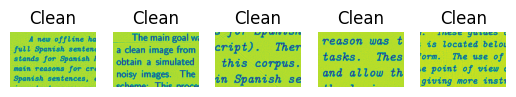

Epoch 75, loss 0.00117


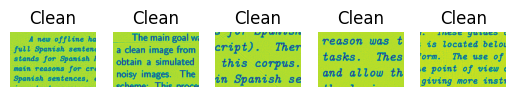

Epoch 78, loss 0.00115


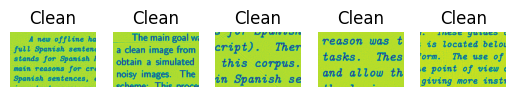

Epoch 81, loss 0.00112


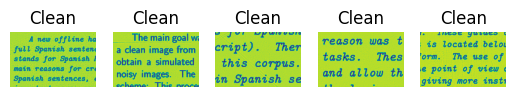

Epoch 84, loss 0.00110


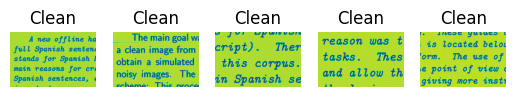

Epoch 87, loss 0.00107


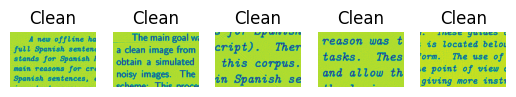

Epoch 90, loss 0.00105


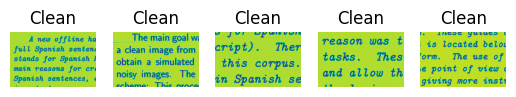

Epoch 93, loss 0.00103


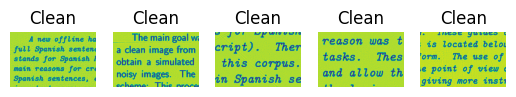

Epoch 96, loss 0.00102


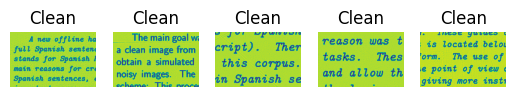

Epoch 99, loss 0.00102


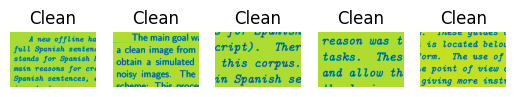

Epoch 102, loss 0.00099


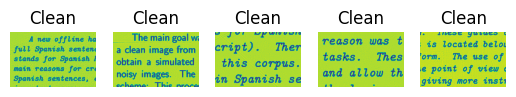

Epoch 105, loss 0.00097


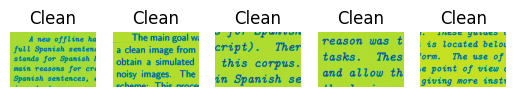

Epoch 108, loss 0.00094


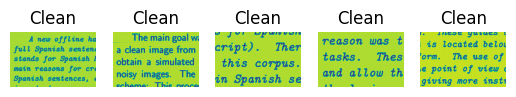

Epoch 111, loss 0.00094


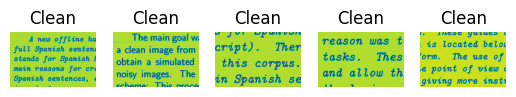

Epoch 114, loss 0.00091


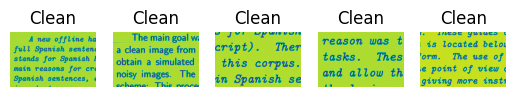

Epoch 117, loss 0.00090


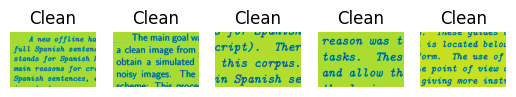

Epoch 120, loss 0.00089


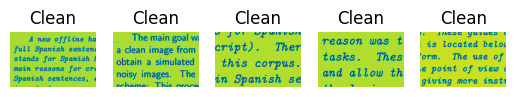

Epoch 123, loss 0.00086


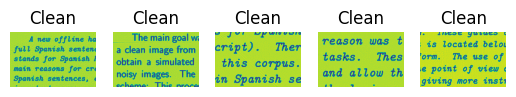

Epoch 126, loss 0.00087


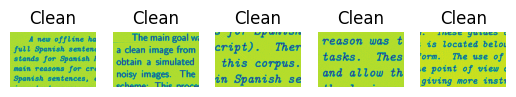

Epoch 129, loss 0.00085


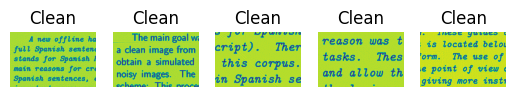

Epoch 132, loss 0.00082


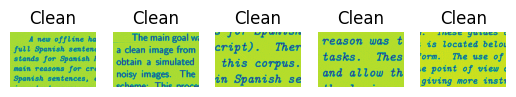

Epoch 135, loss 0.00081


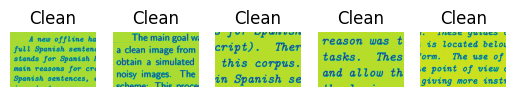

Epoch 138, loss 0.00081


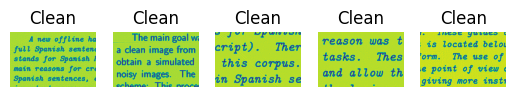

Epoch 141, loss 0.00080


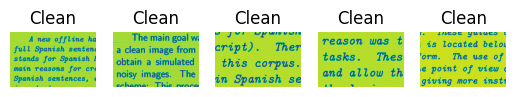

Epoch 144, loss 0.00079


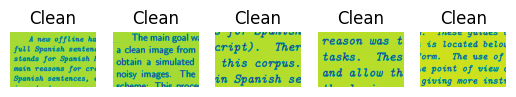

Epoch 147, loss 0.00077


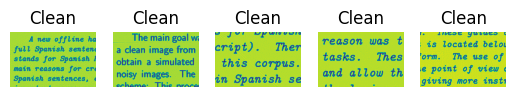

Epoch 150, loss 0.00077


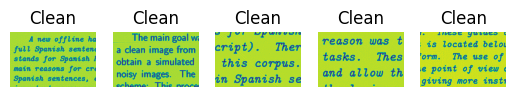

Epoch 153, loss 0.00075


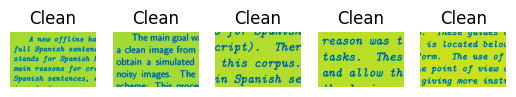

Epoch 156, loss 0.00074


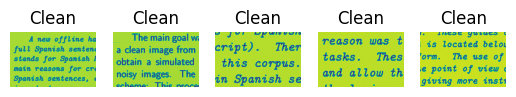

Epoch 159, loss 0.00073


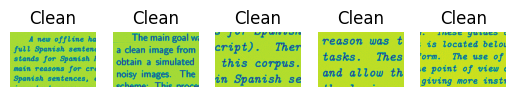

Epoch 162, loss 0.00072


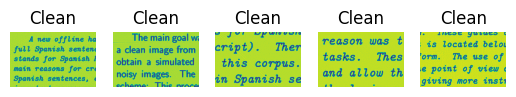

Epoch 165, loss 0.00072


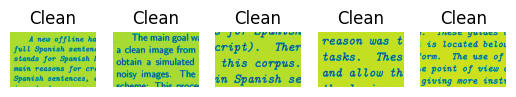

Epoch 168, loss 0.00072


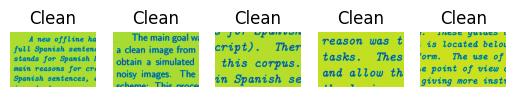

Epoch 171, loss 0.00069


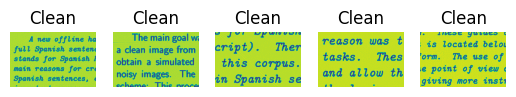

Epoch 174, loss 0.00068


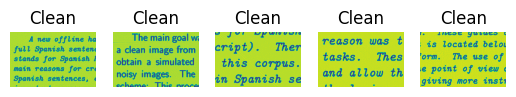

Epoch 177, loss 0.00068


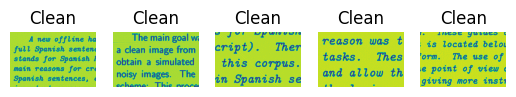

Epoch 180, loss 0.00066


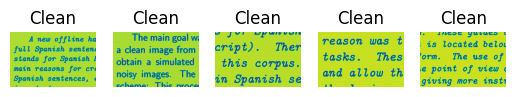

Epoch 183, loss 0.00066


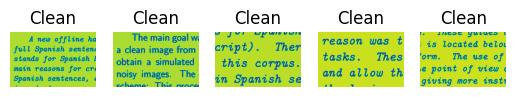

Epoch 186, loss 0.00066


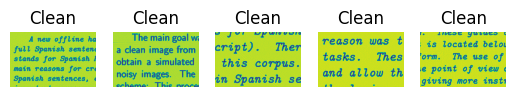

KeyboardInterrupt: ignored

In [ ]:
loss_fn = nn.MSELoss()
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(2000):
    for i in range(len(X_train_torch)):
        optimizer.zero_grad()
        X = X_train_torch[i].to(device)
        X_clean = X_clean_train_torch[i].to(device)
        X_pred = model(X)
        loss = loss_fn(X_pred, X_clean)
        loss.backward()
        optimizer.step()
    if epoch % 3 == 0:
      print(f"Epoch {epoch}, loss {loss.item():.5f}")
      batch_size_test = 14
      X_test = X_test.reshape(-1, batch_size_test, width, height)
      X_test_expanded = np.expand_dims(X_test, axis=2)
      X_test_torch = torch.from_numpy(X_test_expanded).float()
      predictions = []
      for i in range(len(X_test_torch)):
          X = X_test_torch[i].to(device)
          X_pred = model(X).to(device)
          predictions.append(X_pred.detach().cpu().numpy())
      predictions = np.array(predictions)
      predictions = predictions.reshape(-1, width, height)
      for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.imshow(predictions[i])
        plt.title("Clean")
        plt.axis('off')
      plt.show()

## Prédiction

In [ ]:
batch_size_test = 14
X_test = X_test.reshape(-1, batch_size_test, width, height)
X_test_expanded = np.expand_dims(X_test, axis=2)
X_test_torch = torch.from_numpy(X_test_expanded).float()

predictions = []
for i in range(len(X_test_torch)):
    X = X_test_torch[i].to(device)
    X_pred = model(X).to(device)
    predictions.append(X_pred.detach().cpu().numpy())

predictions = np.array(predictions)
predictions = predictions.reshape(-1, width, height)

np.save('predictions.npy', predictions)

## Visualiser les résultats

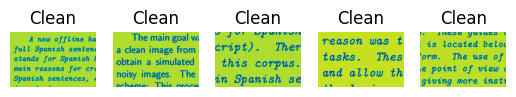

In [ ]:
for i in range(5):
	plt.subplot(2, 5, i + 6)
	plt.imshow(predictions[i])
	plt.title("Clean")
	plt.axis('off')